In [1]:
!pip install gdown

In [2]:
!gdown https://drive.google.com/uc?id=1LjkBrp8mQESKnlAA37wYZU7YEMAGwtf6
!gdown https://drive.google.com/uc?id=1--Ii6naNrQTAs9b8iIsIMdOm-FKebqNU

Downloading...
From (original): https://drive.google.com/uc?id=1LjkBrp8mQESKnlAA37wYZU7YEMAGwtf6
From (redirected): https://drive.google.com/uc?id=1LjkBrp8mQESKnlAA37wYZU7YEMAGwtf6&confirm=t&uuid=33852c9e-8d35-4422-be3e-859faa40cabe
To: /kaggle/working/train_image_embeddings.npy
100%|█████████████████████████████████████████| 662M/662M [00:02<00:00, 232MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1--Ii6naNrQTAs9b8iIsIMdOm-FKebqNU
From (redirected): https://drive.google.com/uc?id=1--Ii6naNrQTAs9b8iIsIMdOm-FKebqNU&confirm=t&uuid=fd592080-b7b7-4f6c-9fd9-e5ad85744399
To: /kaggle/working/train_text_embeddings.npy
100%|█████████████████████████████████████████| 662M/662M [00:02<00:00, 276MB/s]


In [3]:
import numpy as np
import pandas as pd

In [4]:
train_image_embeddings = np.load('train_image_embeddings.npy')
train_text_embeddings = np.load('train_text_embeddings.npy')

In [5]:
train_image_embed = np.squeeze(train_image_embeddings)
train_text_embed = np.squeeze(train_text_embeddings)

In [6]:
train = pd.read_csv('/kaggle/input/content/query_frame_annotations_train.csv')
validation = pd.read_csv('/kaggle/input/content/query_frame_annotations_val.csv')
test = pd.read_csv('/kaggle/input/content/query_frame_annotations_test.csv')

In [7]:
train_labels = train['Relevance'].values

In [8]:
# X_train_add = train_image_embed + train_text_embed
X_train_add = train_image_embed * train_text_embed
# X_train_add = np.concatenate((train_image_embed, train_text_embed), axis=1)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [10]:
# Parameters
input_size = 1024  # Number of input features
# input_size = 2048
num_classes = 4  # Number of output classes, adjust as per your dataset
batch_size = 256  # Batch size for training
epochs = 100  # Number of epochs to train for
hidden_size = 512

In [11]:
# Dataset and DataLoader
dataset = TensorDataset(torch.tensor(X_train_add), torch.tensor(train_labels))
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model
# class SimpleNN(nn.Module):
#     def __init__(self, input_size, num_classes):
#         super(SimpleNN, self).__init__()
#         self.linear = nn.Linear(input_size, num_classes)

#     def forward(self, x):
#         out = self.linear(x)
#         return out
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # First hidden layer
        self.relu = nn.ReLU()                          # Activation function for hidden layers
        self.fc2 = nn.Linear(hidden_size, hidden_size) # Second hidden layer
        self.fc3 = nn.Linear(hidden_size, num_classes) # Output layer

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

model = SimpleNN(input_size,hidden_size ,num_classes)
model = model.double()
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

SimpleNN(
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=4, bias=True)
)

In [12]:
epoch_losses = []
epoch_accuracies = []


In [13]:
train_labels

array([0, 0, 2, ..., 1, 3, 3])

In [14]:
for epoch in range(epochs):
    total = 0
    correct = 0
    epoch_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        # Move data to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    epoch_losses.append(epoch_loss / len(train_loader))
    epoch_accuracies.append(100 * correct / total)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss / len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')

print('Training complete.')

Epoch [1/100], Step [100/316], Loss: 0.9570
Epoch [1/100], Step [200/316], Loss: 1.0979
Epoch [1/100], Step [300/316], Loss: 1.0524
Epoch [1/100], Loss: 1.0409, Accuracy: 52.40%
Epoch [2/100], Step [100/316], Loss: 1.0130
Epoch [2/100], Step [200/316], Loss: 0.9557
Epoch [2/100], Step [300/316], Loss: 0.8964
Epoch [2/100], Loss: 0.9795, Accuracy: 54.85%
Epoch [3/100], Step [100/316], Loss: 0.9865
Epoch [3/100], Step [200/316], Loss: 0.8863
Epoch [3/100], Step [300/316], Loss: 0.9466
Epoch [3/100], Loss: 0.9650, Accuracy: 55.13%
Epoch [4/100], Step [100/316], Loss: 0.9091
Epoch [4/100], Step [200/316], Loss: 0.9564
Epoch [4/100], Step [300/316], Loss: 0.9654
Epoch [4/100], Loss: 0.9531, Accuracy: 55.42%
Epoch [5/100], Step [100/316], Loss: 0.9145
Epoch [5/100], Step [200/316], Loss: 1.0389
Epoch [5/100], Step [300/316], Loss: 0.9507
Epoch [5/100], Loss: 0.9455, Accuracy: 55.70%
Epoch [6/100], Step [100/316], Loss: 0.8945
Epoch [6/100], Step [200/316], Loss: 0.9293
Epoch [6/100], Step [3

In [15]:
# Save the trained model
torch.save(model.state_dict(), 'simple_nn_model.pth')

print('Training complete.')


Training complete.


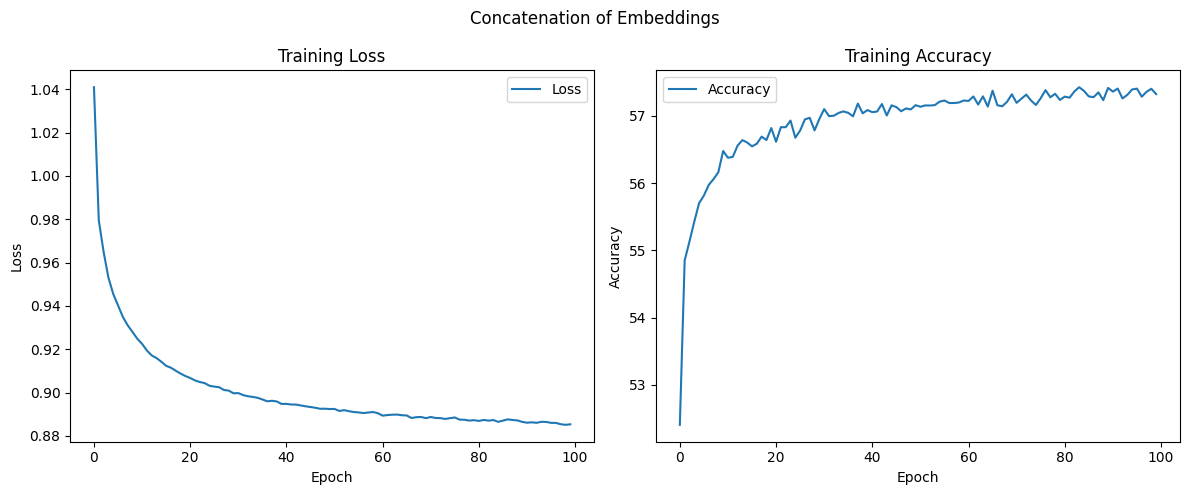

In [16]:
# Plot training loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epoch_losses, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_accuracies, label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.suptitle('Concatenation of Embeddings')

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()